**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [2]:
!pip install fastai --upgrade -q

In [3]:
from fastai.vision.all import *

from fastai.metrics import accuracy_multi
from torchvision.models import resnet34

import PIL

In [4]:
path = Path('drive/My Drive/Dataset/RFMID/data')

In [5]:
!ls 'drive/My Drive/Dataset/RFMID/data/Training_Set/Training/' -1 | wc -l

1920


### Get Data

In [6]:
df = pd.read_csv(path/'Training_Set/RFMiD_Training_Labels.csv')

In [7]:
df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Disease Screening Data

In [11]:
def get_dls(bs, size):
  batch_tfms = [*aug_transforms(do_flip=True, flip_vert=True, max_rotate=180, min_zoom=1.0, max_zoom=1.2, size=size, min_scale=0.75), Normalize]

  dblock = DataBlock(blocks=(ImageBlock(),CategoryBlock()),
                     splitter=RandomSplitter(),
                    get_x=ColReader(0, pref=f'{path}/Training_Set/Training/', suff='.png'),
                    get_y=ColReader(1),
                    item_tfms=Resize(1024),
                    batch_tfms=batch_tfms)
  
  return dblock.dataloaders(df, bs=bs)

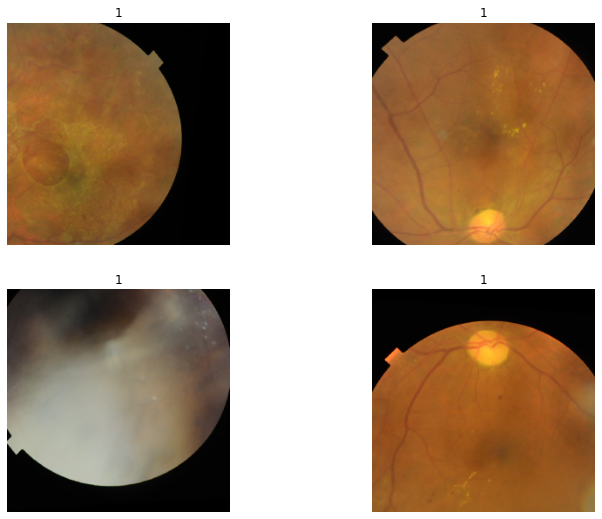

In [12]:
dls = get_dls(16, 256)
dls.show_batch(max_n=4, figsize=(12,9))

### Disease Classification Data

In [ ]:
classes = list(df.columns[2:])

In [ ]:
def get_y(r): return r[classes].values.astype(np.int32)

In [ ]:
def get_dls(bs, size):
  batch_tfms = [*aug_transforms(do_flip=True, flip_vert=True, max_rotate=180, min_zoom=1.0, max_zoom=1.2, size=size, min_scale=0.75), Normalize]

  dblock = DataBlock(blocks=(ImageBlock(),MultiCategoryBlock(encoded=True,vocab=classes)),
                    splitter=RandomSplitter(),
                    get_x=ColReader(0,pref=f'{path}/Training_Set/Training/', suff='.png'),
                    get_y=get_y,
                    item_tfms=Resize(1024),
                    batch_tfms=batch_tfms)
  
  return dblock.dataloaders(df, bs=bs)

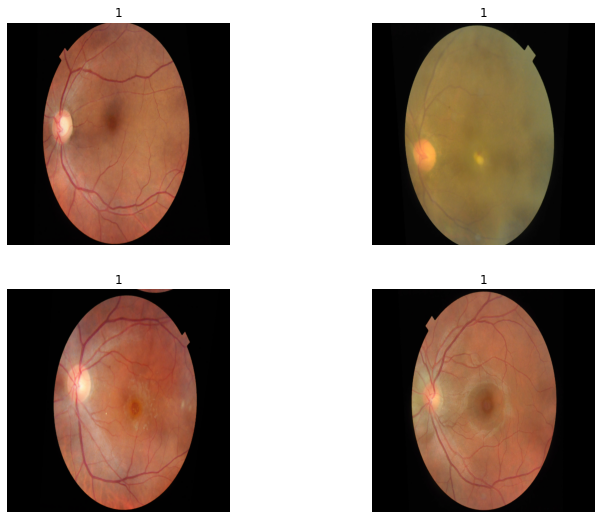

In [ ]:
dls = get_dls(16, 256)
dls.show_batch(max_n=4, figsize=(12,9))

## Train Model

### Disease Screening

In [13]:
model = xresnet50(n_out=dls.c)

In [14]:
screener = Learner(dls, model, metrics=[accuracy, RocAucBinary()], loss_func=CrossEntropyLossFlat(), cbs=MixUp())
screener = screener.to_fp16()

In [15]:
screener.freeze()
screener.fit_one_cycle(5, 3e-04)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.586947,0.480845,0.825521,0.749629,04:28
1,0.543859,0.455447,0.841146,0.774935,04:27
2,0.492379,0.428828,0.828125,0.787751,04:21
3,0.443960,0.415658,0.822917,0.791783,04:13
4,0.443690,0.392178,0.830729,0.813274,04:19


In [16]:
screener.freeze_to(-1)
screener.fit_one_cycle(5, 6e-4)

KeyboardInterrupt: ignored

In [ ]:
screener.freeze_to(-2)
screener.fit_one_cycle(5, 1e-5)

In [ ]:
screener.freeze_to(-3)
screener.fit_one_cycle(5, 5e-5)

In [ ]:
screener.dls = get_dls(8, 512)

### Multi-Label

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
model = xresnet50(n_out=d_dls.c)

In [ ]:
classifier = Learner(d_dls, model, metrics=[accuracy_multi], loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.14454397559165955)

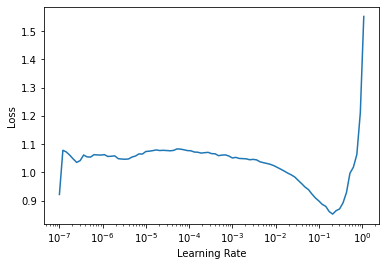

In [ ]:
classifier.lr_find()

In [ ]:
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, slice(5e-02))

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.101087,8.582694,0.148810,00:04
1,0.889292,1.340969,0.613095,00:04
2,0.679198,0.450824,0.934524,00:04
3,0.573460,0.530299,0.946429,00:04
4,0.510926,0.534044,0.946429,00:04
